In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from google.colab import drive
import zipfile

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Unzipping dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Project datasets/ChestXRay2017.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


In [ ]:
# Define paths
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"

In [ ]:
# Augmentation and normalization
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)


In [ ]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=0
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Load pre-trained DenseNet121 and enable fine-tuning
from keras.applications import DenseNet121
conv_base = DenseNet121(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3),
                        pooling='avg')

for layer in conv_base.layers[:200]:  # Fine-tune last layers
    layer.trainable = False


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Model definition
model = keras.models.Sequential([
    conv_base,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7991 - loss: 0.4200 - precision: 0.8635 - recall: 0.8602
Epoch 1: val_loss improved from inf to 0.22137, saving model to best_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.7996 - loss: 0.4191 - precision: 0.8638 - recall: 0.8606 - val_accuracy: 0.9151 - val_loss: 0.2214 - val_precision: 0.9181 - val_recall: 0.9487 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9501 - loss: 0.1269 - precision: 0.9673 - recall: 0.9641
Epoch 2: val_loss did not improve from 0.22137
164/164 ━━━━━━━━━━━━━━━━━━━━ 177s 735ms/step - accuracy: 0.9501 - loss: 0.1268 - precision: 0.9673 - recall: 0.9642 - val_accuracy: 0.9199 - val_loss: 0.2692 - val_precision: 0.8991 - val_recall: 0.9821 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9569 - loss: 0.1117 - precision: 0.9677 - recall: 0.9748
Epoch 3: val_loss did not improve from 0.22137
164/1

In [ ]:
# Load the best saved model
model = keras.models.load_model('best_model.keras')

In [ ]:
# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - accuracy: 0.8957 - loss: 0.3018 - precision: 0.5371 - recall: 0.6238
Test Accuracy: 0.92
Test Precision: 0.92
Test Recall: 0.95


In [ ]:

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.2f}")

F1-Score: 0.93


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 672ms/step


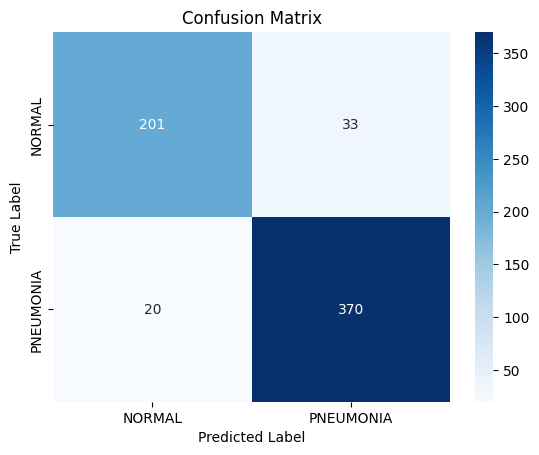

In [ ]:
# Confusion matrix
test_generator.reset()
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.86      0.88       234
   PNEUMONIA       0.92      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.92      0.91       624



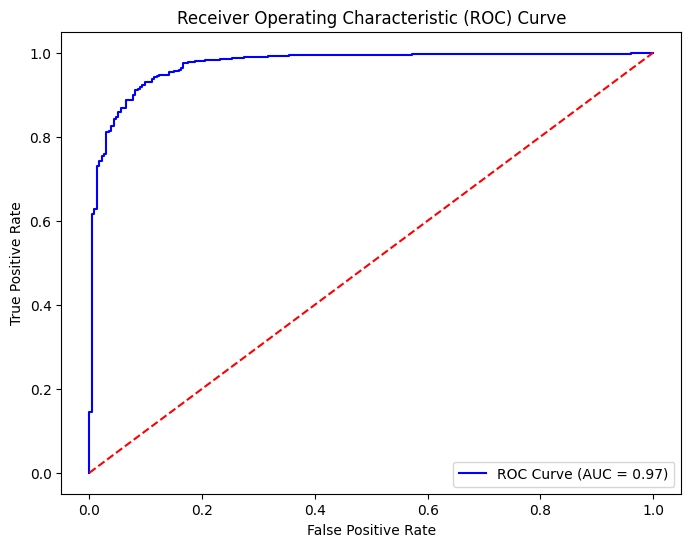

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from google.colab import files
model.save('best_model.keras')
files.download('best_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>